Reference : 
https://github.com/uosdmlab/tensorflow-tutorial/blob/master/notebooks/4.MNIST%20with%20CNN.ipynb
https://www.kaggle.com/innerproduct/state-farm-distracted-driver-detection/tensorflow

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
DROPOUT=0.5
TRAINING_ITERATIONS =10000
LEARNING_RATE = 1e-4
Validation_size=1000
BATCH_SIZE=50

In [2]:
data=pd.read_csv('~/Documents/GIT_HUB/MNIST/train.csv')

In [3]:
images=data.iloc[:,1:].values.astype(np.float);
images=np.multiply(images,1.0/255.0);
#this is done to change the shape of the array
image_size=images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

In [4]:
labels_count=data[[0]].values.ravel()
label = np.unique(labels_count).shape[0]

In [5]:
def dense(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    res=np.zeros(shape=(num_labels,num_classes));
    for i in range (0,num_labels):
        res[i,labels_dense[i]]=1;
    return res;

hot_label=dense(labels_count,label);
hot_label = hot_label.astype(np.uint8)

In [6]:
validation_images=images[:Validation_size]
validation_labels=hot_label[:Validation_size]
train_images=images[Validation_size:]
train_labels=hot_label[Validation_size:]

Added guassian layer to increase the number of samples , by adding another layer we were able to generate more number of training samples.


In [7]:
# weight initialization
def w_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def b_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def mpool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

In [8]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]
# serve data by batches
def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    start = index_in_epoch
    index_in_epoch += batch_size
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [9]:
std=tf.placeholder('float');
x = tf.placeholder('float', shape=[None, image_size]);
#W=tf.placeholder('float',shape=[images.shape[1],10])
y_=tf.placeholder('float',shape=[None,label])
train_=tf.placeholder('int32');
keep_prob = tf.placeholder('float')
keep_prob1 = tf.placeholder('float')

In [10]:
W_conv1 = w_variable([5, 5, 1, 32])
b_conv1 = b_variable([32])
image = tf.reshape(x, [-1,image_width , image_height,1]);
if train_==1:
    image=gaussian_noise_layer(image,std);
    resized_image = tf.image.resize_images(image, [32, 32])
    distorted_image = tf.random_crop(resized_image, [28, 28, 1])
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    image = tf.image.per_image_whitening(distorted_image)
graph = tf.get_default_graph()
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
h_pool1 = mpool(h_conv1)
#h_pool1 = tf.nn.dropout(h_pool1,keep_prob1);
# second convolutional layer
W_conv2 = w_variable([5, 5, 32, 64])
b_conv2 = b_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = mpool(h_conv2)
W_conv3=w_variable([1,1,64,64])
b_conv3=b_variable([64])
h_pool2=tf.nn.relu(conv2d(h_pool2,W_conv3)+b_conv3);
#h_pool2 = tf.nn.dropout(h_pool2,keep_prob1);
W_fc1 = w_variable([7 * 7 * 64, 1024])
b_fc1 = b_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
#this is the output layer
W_fc2 = w_variable([1024, label])
b_fc2 = b_variable([label])
y = tf.nn.log_softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
# optimisation function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y,1)
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
saver = tf.train.Saver()

In [11]:
check=input('Enter do you wanna load file or run a new model');
if check=='yes' or check=='YES':
    LOAD_FILE=input("Enter the name of the model to load the tensorflow model");
    try:
        saver = tf.train.import_meta_graph(LOAD_FILE+'.meta');
        saver.restore(sess, LOAD_FILE)
    except :
        print('File Do not exist')
else:
    sess.run(init)
    SAVING_FILE=input("Enter the name of the model to save the tensorflow");
# evaluation

Enter do you wanna load file or run a new modelyes
Enter the name of the model to load the tensorflow modelmodel1.ckpt


In [12]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []
display_step=1
for i in range(TRAINING_ITERATIONS):
    #get new batch
    batch_xs, batch_ys = next_batch(50) 
    if(i%100==0):
        print(i)
        if(Validation_size):#this is done to make sure that in case we make validation size 0 , we can simply avoid printing it
            validation_accuracies.append(sess.run(accuracy,feed_dict={x:validation_images,y_:validation_labels,keep_prob:1.0,std:0.0,train_:0}));
            train_accuracies.append((sess.run(accuracy,feed_dict={x:batch_xs,y_:batch_ys,keep_prob:1.0,std:0.0,train_:0})));
            print(validation_accuracies[len(validation_accuracies)-1]);   
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT,std:0.0,train_:1})
if check=='Yes' or check=='yes':
    check_1=input("Do you want to save file with same name or not?(yes/No)");
    if(check_1=='no'):
        temp=input("File name");
        saver.save(sess,temp);
    else:
        saver.save(sess,LOAD_FILE);
else:
    saver.save(sess, SAVING_FILE);#this is where we save our training model which can be used later

0
0.992
100
0.985
200
0.989
300
0.987
400
0.992
500
0.989
600
0.994
700
0.99
800
0.991
900
0.989
1000
0.991
1100
0.992
1200
0.993
1300
0.992
1400
0.991
1500
0.991
1600
0.988
1700
0.992
1800
0.989
1900
0.989
2000
0.991
2100
0.993
2200
0.993
2300
0.991
2400
0.992
2500
0.99
2600
0.991
2700
0.995
2800
0.993
2900
0.993
3000
0.992
3100
0.99
3200
0.991
3300
0.992
3400
0.992
3500
0.992
3600
0.992
3700
0.992
3800
0.992
3900
0.989
4000
0.99
4100
0.995
4200
0.991
4300
0.994
4400
0.994
4500
0.993
4600
0.992
4700
0.993
4800
0.993
4900
0.991
5000
0.991
5100
0.989
5200
0.989
5300
0.989
5400
0.992
5500
0.993
5600
0.99
5700
0.99
5800
0.992
5900
0.989
6000
0.993
6100
0.989
6200
0.991
6300
0.994
6400
0.994
6500
0.992
6600
0.994
6700
0.993
6800
0.993
6900
0.993
7000
0.992
7100
0.993
7200
0.991
7300
0.993
7400
0.99
7500
0.991
7600
0.992
7700
0.993
7800
0.992
7900
0.991
8000
0.992
8100
0.992
8200
0.99
8300
0.993
8400
0.99
8500
0.992
8600
0.994
8700
0.993
8800
0.991
8900
0.992
9000
0.992
9100
0.993
9200
0.99

0.993


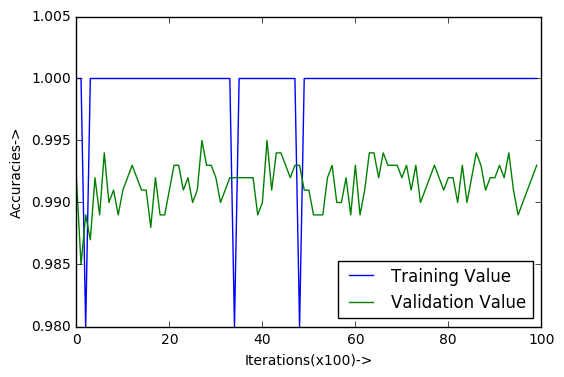

In [13]:
print(validation_accuracies[len(validation_accuracies)-1]);
line1=plt.plot(train_accuracies,label='Training Value')
line2=plt.plot(validation_accuracies,label='Validation Value')
plt.legend(loc=4)
plt.ylabel('Accuracies->');
plt.xlabel('Iterations(x100)->');
plt.show()